In [8]:
# ===== SPEED HEADER =====
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_MAX_THREADS"] = "1"

N_JOBS = 18
RANDOM_STATE = 42

# ===== Imports =====
import numpy as np
import pandas as pd
from math import sqrt

from numpy.linalg import inv
from joblib import Parallel, delayed
from threadpoolctl import threadpool_limits
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython.display import display


In [9]:
# ===== Paths =====
SAVE_DIR   = '../Extended Parametric Regression Files+Plots'
TRAIN_CSV  = f'{SAVE_DIR}/train.csv'
TEST_CSV   = f'{SAVE_DIR}/test.csv'
FOLDS_NPY  = f'{SAVE_DIR}/train_folds.npy'   # must exist

# ===== Load =====
df_train = pd.read_csv(TRAIN_CSV)
df_train["_rowpos"] = np.arange(len(df_train), dtype=int)   # preserve original order for folds
df_test  = pd.read_csv(TEST_CSV)

# (Optional) If you reorder/decimate df_train, do it here; _rowpos keeps folds aligned.
# df_train = df_train.sort_values('time').reset_index(drop=True)

# ===== Column sanity =====
required_cols = ['PL','distance','frequency','c_walls','w_walls',
                 'co2','humidity','pm25','pressure','temperature','snr']
missing = [c for c in required_cols if c not in df_train.columns or c not in df_test.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# ===== Folds: load + remap to current df_train =====
fold_assignments_full = np.load(FOLDS_NPY)
rowpos = df_train["_rowpos"].to_numpy(dtype=int)
if rowpos.max() >= len(fold_assignments_full):
    raise ValueError("train.csv and train_folds.npy are out of sync.")
fold_assignments = fold_assignments_full[rowpos]
K = int(fold_assignments.max()) + 1
folds = [(np.where(fold_assignments != k)[0], np.where(fold_assignments == k)[0]) for k in range(K)]
print(f"[CV] Using saved folds (remapped) | K={K} | n_train={len(df_train)} | fold sizes={[len(v) for _, v in folds]}")


[CV] Using saved folds (remapped) | K=5 | n_train=1341431 | fold sizes=[268287, 268286, 268286, 268286, 268286]


In [10]:
# ===== Physics helpers =====
d0 = 1.0
def z_of_d(d):  d = np.clip(np.asarray(d,float),1e-6,None); return 10.0*np.log10(d/d0)
def f_term(f):  f = np.clip(np.asarray(f,float),1e-12,None); return 20.0*np.log10(f)

# ===== Features & targets =====
raw_feats  = ['distance','frequency','c_walls','w_walls','co2','humidity','pm25','pressure','temperature','snr']
target_col = 'PL'

Xtr_raw = df_train[raw_feats].copy()
Xte_raw = df_test[raw_feats].copy()
ytr_pl  = df_train[target_col].astype(float).values
yte_pl  = df_test[target_col].astype(float).values

# Friis-adjusted targets (fit space)
ftr_tr, ftr_te = f_term(Xtr_raw['frequency']), f_term(Xte_raw['frequency'])
ytr_adj, yte_adj = ytr_pl - ftr_tr, yte_pl - ftr_te

# Linear (physics) feature map
LIN_COLS = ['z_d','c_walls','w_walls','co2','humidity','pm25','pressure','temperature','snr']
Xtr_lin = pd.DataFrame({
    'z_d': z_of_d(Xtr_raw['distance']),
    'c_walls': Xtr_raw['c_walls'],
    'w_walls': Xtr_raw['w_walls'],
    'co2': Xtr_raw['co2'],
    'humidity': Xtr_raw['humidity'],
    'pm25': Xtr_raw['pm25'],
    'pressure': Xtr_raw['pressure'],
    'temperature': Xtr_raw['temperature'],
    'snr': Xtr_raw['snr']
}, columns=LIN_COLS).to_numpy()

Xte_lin = pd.DataFrame({
    'z_d': z_of_d(Xte_raw['distance']),
    'c_walls': Xte_raw['c_walls'],
    'w_walls': Xte_raw['w_walls'],
    'co2': Xte_raw['co2'],
    'humidity': Xte_raw['humidity'],
    'pm25': Xte_raw['pm25'],
    'pressure': Xte_raw['pressure'],
    'temperature': Xte_raw['temperature'],
    'snr': Xte_raw['snr']
}, columns=LIN_COLS).to_numpy()


In [11]:
class FullBLRConjugate(BaseEstimator, RegressorMixin):
    """
    Conjugate BLR with Normal–Inverse-Gamma prior:
      beta | sigma^2 ~ N(beta0, sigma^2 V0)
      sigma^2        ~ Inv-Gamma(a0, b0)

    prior = 'g-prior' uses V0 = g * (X'X)^(-1) on slopes only (intercept unshrunk).
    g_mode: 'uip' (g=n), 'eb' (closed-form EB), or 'fixed' (user g_value).
    """
    def __init__(self, beta0=None, a0=1e-2, b0=1e-2,
                 prior='g-prior', g_mode='uip', g_value=None):
        self.beta0 = beta0
        self.a0 = a0; self.b0 = b0
        self.prior = prior
        self.g_mode = g_mode
        self.g_value = g_value
        # fitted
        self.beta_n_ = None; self.Vn_ = None; self.an_ = None; self.bn_ = None
        self.g_ = None         # g used
        self.R2_ = None        # R^2 used in EB

    def _augment(self, X):
        n = X.shape[0]
        return np.hstack([np.ones((n,1)), X])

    @staticmethod
    def _ols_R2_centered(X, y):
        """
        Compute OLS R^2 with centered y (no intercept in X).
        Assumes X already standardized (mean ~ 0).
        """
        y = np.asarray(y, float).reshape(-1)
        y_c = y - y.mean()
        if y_c.size == 0:
            return 0.0
        tss = float(np.dot(y_c, y_c))
        if tss <= 0:
            return 0.0
        XtX = X.T @ X
        # OLS beta without intercept on centered y
        beta_hat = np.linalg.pinv(XtX) @ (X.T @ y_c)
        y_hat = X @ beta_hat
        rss = float(np.dot(y_c - y_hat, y_c - y_hat))
        R2 = 1.0 - rss / tss
        # numerical guard
        return float(np.clip(R2, 0.0, 1.0))

    def _eb_g_closed_form(self, X, y):
        """
        Closed-form EB g maximizing marginal likelihood under g-prior:
            g_hat = max(0, ((n-1)R^2 - p) / (p*(1 - R^2))).
        (See e.g., Zellner/Liang et al.)
        """
        n, p = X.shape
        if p == 0:
            return 0.0, 0.0
        R2 = self._ols_R2_centered(X, y)
        eps = 1e-12
        R2c = min(R2, 1.0 - eps)
        num = (n - 1) * R2c - p
        den = p * (1.0 - R2c)
        g_hat = max(0.0, num / den)
        # avoid total collapse numerically
        g_hat = max(g_hat, 1e-6)
        return g_hat, R2

    def fit(self, X, y):
        X = np.asarray(X, float)
        y = np.asarray(y, float).reshape(-1)

        X_aug = self._augment(X)
        n, d = X_aug.shape  # d = 1 + p

        if self.beta0 is None:
            self.beta0 = np.zeros(d)
        beta0 = self.beta0

        if self.prior != 'g-prior':
            raise ValueError("This implementation expects prior='g-prior'.")

        # choose g
        if self.g_mode == 'uip':
            g = float(n)  # unit-information prior
            R2_used = None
        elif self.g_mode == 'fixed':
            if self.g_value is None:
                raise ValueError("g_mode='fixed' requires g_value.")
            g = float(self.g_value); R2_used = None
        elif self.g_mode == 'eb':
            g, R2_used = self._eb_g_closed_form(X, y)
        else:
            raise ValueError("g_mode must be 'uip', 'fixed', or 'eb'.")

        self.g_, self.R2_ = g, R2_used

        # Prior precision V0^{-1}: slopes get (1/g) X'X, intercept gets 0 (unshrunk)
        XtX = X.T @ X
        V0_inv = np.zeros((d, d))
        V0_inv[1:, 1:] = (1.0 / g) * XtX

        # Posterior
        XtX_aug = X_aug.T @ X_aug
        Vn_inv = V0_inv + XtX_aug
        Vn = np.linalg.inv(Vn_inv)

        Xty = X_aug.T @ y
        beta_n = Vn @ (V0_inv @ beta0 + Xty)

        an = self.a0 + 0.5 * n
        resid = y - X_aug @ beta_n
        term = (beta_n - beta0).T @ V0_inv @ (beta_n - beta0)
        bn = self.b0 + 0.5 * (resid @ resid + term)

        self.beta_n_, self.Vn_, self.an_, self.bn_ = beta_n, Vn, an, bn
        return self

    def predict(self, X, return_std=False):
        X = np.asarray(X, float)
        X_aug = self._augment(X)
        mean = X_aug @ self.beta_n_
        if not return_std:
            return mean
        pred_var = (self.bn_ / self.an_) * (1.0 + np.sum(X_aug @ self.Vn_ * X_aug, axis=1))
        return mean, np.sqrt(np.maximum(pred_var, 0.0))

In [12]:
def make_BLR_linear(cfg):
    return make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        FullBLRConjugate(
            prior='g-prior',
            g_mode=cfg.get("g_mode", "uip"),   # 'uip' | 'eb' | 'fixed'
            g_value=cfg.get("g_value", None),
            a0=cfg.get("a0", 1e-2),
            b0=cfg.get("b0", 1e-2)
        )
    )

# Two principled options: UIP and EB (you can add 'fixed' if you want)
blr_specs = [("BLR-Linear (g-prior)", make_BLR_linear, [
    dict(g_mode="uip", a0=1e-2, b0=1e-2),   # g = n
    dict(g_mode="eb",  a0=1e-2, b0=1e-2),   # empirical Bayes g
])]

def rmse_r2_on_PL(y_true_pl, y_pred_adj, fterm):
    y_pred_pl = y_pred_adj + fterm
    rmse = sqrt(((y_true_pl - y_pred_pl)**2).mean())
    ss_res = np.sum((y_true_pl - y_pred_pl)**2)
    ss_tot = np.sum((y_true_pl - y_true_pl.mean())**2)
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return rmse, r2

def unscale_blr_posterior(pipeline, feature_names):
    steps = pipeline.named_steps
    est = steps['fullblrconjugate']
    beta = est.beta_n_                 # (p+1,)
    Vn = est.Vn_
    scale_var = est.bn_ / est.an_      # matches predictive scaling
    cov_scaled = scale_var * Vn

    if 'standardscaler' not in steps:
        names = ["Intercept"] + feature_names
        return names, beta.copy(), cov_scaled.copy()

    scaler = steps['standardscaler']
    mu = scaler.mean_.astype(float)
    sig = scaler.scale_.astype(float)
    p = len(mu)

    # Linear transform from scaled to original units
    T = np.zeros((p+1, p+1))
    T[0,0] = 1.0; T[0,1:] = -mu / sig
    for j in range(p): T[j+1, j+1] = 1.0 / sig[j]

    mean_orig = T @ beta
    cov_orig  = T @ cov_scaled @ T.T
    names = ["Intercept"] + feature_names
    return names, mean_orig, cov_orig


In [13]:
def eval_cfg_blr(factory, cfg, folds):
    tr_rmse, val_rmse, tr_r2, val_r2 = [], [], [], []
    fold_metrics = []
    for tr_idx, val_idx in folds:
        X_tr, X_val = Xtr_lin[tr_idx], Xtr_lin[val_idx]
        y_tr, y_val = ytr_adj[tr_idx], ytr_adj[val_idx]
        ypl_tr, ypl_val = ytr_pl[tr_idx], ytr_pl[val_idx]
        f_tr,  f_val    = ftr_tr[tr_idx],  ftr_tr[val_idx]

        pipe = factory(cfg)
        with threadpool_limits(limits=1, user_api="blas"):
            pipe.fit(X_tr, y_tr)
            est = pipe.named_steps['fullblrconjugate']
            if est.g_mode == 'eb':
                print(f"    [EB] g={est.g_:.3g}, R2={0.0 if est.R2_ is None else est.R2_:.4f}")

        y_tr_pred = pipe.predict(X_tr)
        rm_tr, r2_tr = rmse_r2_on_PL(ypl_tr, y_tr_pred, f_tr)
        tr_rmse.append(rm_tr); tr_r2.append(r2_tr)

        y_val_pred = pipe.predict(X_val)
        rm_val, r2_val = rmse_r2_on_PL(ypl_val, y_val_pred, f_val)
        val_rmse.append(rm_val); val_r2.append(r2_val)

        fold_metrics.append({
            "rmse_train": rm_tr, "rmse_val": rm_val,
            "r2_train": r2_tr,   "r2_val":  r2_val
        })

    return {
        "cfg": cfg,
        "rmse_train_mean": float(np.mean(tr_rmse)), "rmse_train_sd": float(np.std(tr_rmse)),
        "rmse_val_mean":   float(np.mean(val_rmse)), "rmse_val_sd":   float(np.std(val_rmse)),
        "r2_train_mean":   float(np.mean(tr_r2)),    "r2_train_sd":    float(np.std(tr_r2)),
        "r2_val_mean":     float(np.mean(val_r2)),   "r2_val_sd":      float(np.std(val_r2)),
        "fold_metrics":     fold_metrics,
    }

def _fmt(mu, sd): return f"{mu:.4f} ± {sd:.4f}"

blr_results = []
for name, factory, grid in blr_specs:
    print(f"=== {name} — grid size: {len(grid)}")
    grid_results = Parallel(n_jobs=N_JOBS, backend="threading", prefer="threads")(
        delayed(eval_cfg_blr)(factory, cfg, folds) for cfg in grid
    )

    # Print every config (per-fold + summary) BEFORE selection
    for idx, res in enumerate(grid_results, 1):
        print(f"\n-- {name} | cfg {idx}/{len(grid)}: {res['cfg']}")
        for k, m in enumerate(res["fold_metrics"], 1):
            print(f"Fold {k}: RMSE_train={m['rmse_train']:.4f}, RMSE_val={m['rmse_val']:.4f}")
        print("\n=== Cross-Validation Results on the training set ===")
        print(f"RMSE (Train): {_fmt(res['rmse_train_mean'], res['rmse_train_sd'])}")
        print(f"RMSE (Val):   {_fmt(res['rmse_val_mean'],   res['rmse_val_sd'])}")
        print(f"R2 (Train):   {_fmt(res['r2_train_mean'],   res['r2_train_sd'])}")
        print(f"R2 (Val):     {_fmt(res['r2_val_mean'],     res['r2_val_sd'])}")

    # Pick best by mean Val RMSE
    best = min(grid_results, key=lambda r: r["rmse_val_mean"])
    best_cfg, best_cv = best["cfg"], {k: v for k, v in best.items() if k != "cfg"}
    print(f"\n>>> Best Val RMSE: {best_cv['rmse_val_mean']:.4f} ± {best_cv['rmse_val_sd']:.4f} | cfg={best_cfg}")

    # Refit on all train with best prior
    final_pipe = factory(best_cfg)
    with threadpool_limits(limits=1, user_api="blas"):
        final_pipe.fit(Xtr_lin, ytr_adj)

    # Test metrics (PL domain); also predictive std in adjusted space if needed
    yte_pred_adj, yte_pred_std = final_pipe.predict(Xte_lin, return_std=True)
    test_rmse, test_r2 = rmse_r2_on_PL(yte_pl, yte_pred_adj, ftr_te)

    # Posterior in original units (means, SE)
    names, mean_orig, cov_orig = unscale_blr_posterior(final_pipe, LIN_COLS)
    coef_tbl = pd.DataFrame({
        "mean": mean_orig,
        "std_err": np.sqrt(np.clip(np.diag(cov_orig), 0.0, None))
    }, index=names)

    # Store
    blr_results.append({
        "model": name,
        "best_cfg": best_cfg,
        "cv": best_cv,
        "test": {"rmse": float(test_rmse), "r2": float(test_r2)},
        "final_pipe": final_pipe,
        "coef_tbl": coef_tbl,
        "coeffs": coef_tbl["mean"].copy()
    })

print("Done.")


=== BLR-Linear (g-prior) — grid size: 2
    [EB] g=5.34e+05, R2=0.8173
    [EB] g=5.32e+05, R2=0.8170
    [EB] g=5.34e+05, R2=0.8175
    [EB] g=5.32e+05, R2=0.8170
    [EB] g=5.32e+05, R2=0.8168

-- BLR-Linear (g-prior) | cfg 1/2: {'g_mode': 'uip', 'a0': 0.01, 'b0': 0.01}
Fold 1: RMSE_train=8.0718, RMSE_val=8.0796
Fold 2: RMSE_train=8.0743, RMSE_val=8.0695
Fold 3: RMSE_train=8.0677, RMSE_val=8.0959
Fold 4: RMSE_train=8.0744, RMSE_val=8.0690
Fold 5: RMSE_train=8.0784, RMSE_val=8.0531

=== Cross-Validation Results on the training set ===
RMSE (Train): 8.0733 ± 0.0035
RMSE (Val):   8.0734 ± 0.0141
R2 (Train):   0.8172 ± 0.0002
R2 (Val):     0.8171 ± 0.0010

-- BLR-Linear (g-prior) | cfg 2/2: {'g_mode': 'eb', 'a0': 0.01, 'b0': 0.01}
Fold 1: RMSE_train=8.0718, RMSE_val=8.0796
Fold 2: RMSE_train=8.0743, RMSE_val=8.0695
Fold 3: RMSE_train=8.0677, RMSE_val=8.0959
Fold 4: RMSE_train=8.0744, RMSE_val=8.0690
Fold 5: RMSE_train=8.0784, RMSE_val=8.0531

=== Cross-Validation Results on the training 


=== CV (BLR, g-prior) ===


,Model,RMSE (Train),RMSE (Val),R2 (Train),R2 (Val)
0,BLR-Linear (g-prior),8.0733 ± 0.0035,8.0734 ± 0.0141,0.8172 ± 0.0002,0.8171 ± 0.0010



=== Test (BLR, g-prior) ===


,Model,Test RMSE,Test R2
0,BLR-Linear (g-prior),8.0642,0.8172



=== Posterior Means (original units) ===


,BLR-Linear (g-prior)
Intercept,2.981705
z_d,3.846159
c_walls,6.872952
w_walls,2.012569
co2,-0.002361
humidity,-0.087425
pm25,-0.100704
pressure,-0.009539
temperature,-0.146796
snr,-2.034725



Best by Test RMSE: BLR-Linear (g-prior) | cfg={'g_mode': 'uip', 'a0': 0.01, 'b0': 0.01}


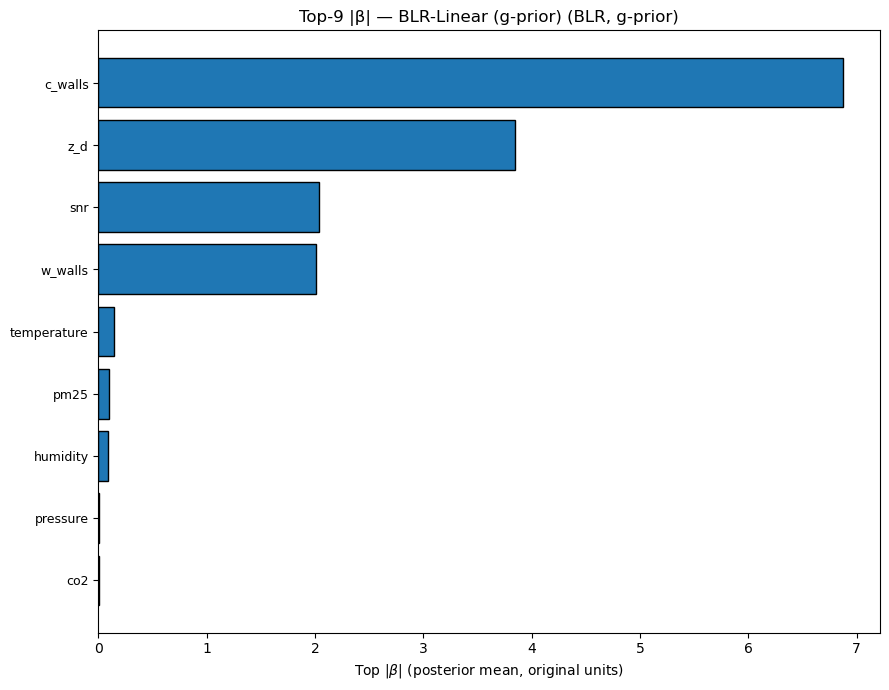

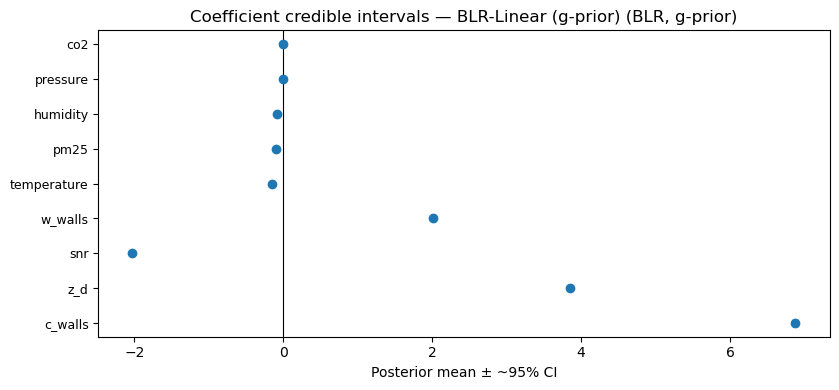

In [14]:
# ===== Tables =====
def fmt(mu, sd): return f"{mu:.4f} ± {sd:.4f}"

cv_rows = []
for r in blr_results:
    cv = r['cv']
    cv_rows.append({"Model": r['model'],
                    "RMSE (Train)": fmt(cv["rmse_train_mean"], cv["rmse_train_sd"]),
                    "RMSE (Val)":   fmt(cv["rmse_val_mean"],   cv["rmse_val_sd"]),
                    "R2 (Train)":   fmt(cv["r2_train_mean"],   cv["r2_train_sd"]),
                    "R2 (Val)":     fmt(cv["r2_val_mean"],     cv["r2_val_sd"])})
cv_blr_df = pd.DataFrame(cv_rows); print("\n=== CV (BLR, g-prior) ==="); display(cv_blr_df)

test_rows = [{"Model": r["model"], "Test RMSE": f'{r["test"]["rmse"]:.4f}', "Test R2": f'{r["test"]["r2"]:.4f}'} for r in blr_results]
test_blr_df = pd.DataFrame(test_rows); print("\n=== Test (BLR, g-prior) ==="); display(test_blr_df)

coef_blr_df = pd.concat([r['coeffs'].rename(r['model']) for r in blr_results], axis=1)
print("\n=== Posterior Means (original units) ==="); display(coef_blr_df)

best = min(blr_results, key=lambda r: r['test']['rmse'])
print(f"\nBest by Test RMSE: {best['model']} | cfg={best['best_cfg']}")

# ===== Plot 1: Top-|beta| (posterior means) =====
coef_ser = best['coeffs']                # includes Intercept
names = coef_ser.index.tolist()
vals = coef_ser.values
mask = np.array([n != 'Intercept' for n in names])
names_noint = np.array(names)[mask]; vals_noint = np.abs(vals[mask])

TOPN = min(25, len(vals_noint))
idx = np.argsort(-vals_noint)[:TOPN]
plt.figure(figsize=(9, 7))
plt.barh(range(TOPN), vals_noint[idx], edgecolor='black')
plt.gca().invert_yaxis()
plt.yticks(range(TOPN), names_noint[idx], fontsize=9)
plt.xlabel(r'Top $|\beta|$ (posterior mean, original units)')
plt.title(f"Top-{TOPN} |β| — {best['model']} (BLR, g-prior)")
plt.tight_layout(); plt.show()

# ===== Plot 2: Coefficient ~95% CI bars =====
coef_tbl = best['coef_tbl'].copy().drop(index='Intercept', errors='ignore')
order = coef_tbl['mean'].abs().sort_values(ascending=False).index
coef_tbl = coef_tbl.loc[order]
y = np.arange(len(coef_tbl))
plt.figure(figsize=(8.5, max(4.0, 0.28*len(coef_tbl))))
plt.errorbar(coef_tbl['mean'], y, xerr=1.96*coef_tbl['std_err'], fmt='o', capsize=3)
plt.yticks(y, coef_tbl.index, fontsize=9)
plt.axvline(0, color='k', linewidth=0.8)
plt.xlabel('Posterior mean ± ~95% CI')
plt.title(f"Coefficient credible intervals — {best['model']} (BLR, g-prior)")
plt.tight_layout(); plt.show()
